In [ ]:
#----------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------- UPDATES 10-14-2025 -------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------

# 1. Found out that np.load loads automatically with complex128 precision but jnp.load downcasts to complex64.
#    This was causing differences between the logpdf_v2 and logpdf_v1 in the 1s place but now error is down to the 
#    hundredths or tens of thousandths place (depending on other factors described more below)

# 2. I was not using rfft2 and irfft2 in the spectral derivative code I have and this caused loss of accuracy

# 3. The only difference in logpdf_v1 and logpdf_v2 besides jax v.s. numpy was using L(phi)*f rather than f_lensed.
#    This got me thinking and there is actually a difference in f_lensed_ground and f_lensed_predict in fourier space
#    that is relatively small ~ 0.07 but has the same exact signal as the error in the jax v.s. ground truth gradients. 
#    Making the above adjustments brought this down from ~ 100 to 4 but gradients are still large since spectral
#    derivative goes like Fourier[df/dx] = ik*Fourier[f] so error gets scaled by large wavevectors and increases in the gradients

# 4. Tried computing analytical gradient of logpdf w.r.t f. This does somewhat better than jax grad but suffers from same
#    suspected LenseFlow error because it of course uses my version of LenseFlow...

# 5. Thought of working on analytical gradient of logpdf w.r.t phi using Fei's idea but decided not to approach that yet since
#    this will likely suffer from the same LenseFlow error

# 6. Bashing head against wall trying to figure out what is wrong with LenseFlow. Tried filtering off higher K-modes using Gaussian 
#    filter and this brings f_lensed error in fourier space down from ~ 4 to ~2.5 but still not helping real space gradients... Also 
#    tried using padding for spectral derivatives but something in the jax or diffrax code does not like this. 

# 7. Got something that can evolve the system / perform gradient descent algorithm. However, this is currently evolving it to 
#    the wrong state since there is a difference in the gradients...

In [1]:
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------- Imports --------------------------------------------------
#------------------------------------------------------------------------------------------------------------

import numpy as np
import math as mt
import jax # type: ignore
jax.config.update("jax_enable_x64", True) #IMPORTANT since julia is default higher precision!
import jax.numpy as jnp # type: ignore
import matplotlib.pyplot as plt # type: ignore
import jax.numpy.fft as jfft # type: ignore
import time
from jax import debug
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt, PIDController, Dopri5, Dopri8, Kvaerno5 # type: ignore
from jax.scipy.sparse.linalg import cg

In [2]:
#------------------------------------------------------------------------------------------------------------
#----------------------------------------  LenseFlow Definition and Helper Functions  -----------------------
#------------------------------------------------------------------------------------------------------------

#reusable plotting code to standardize plots
def plot_heat_map(heatmap, title, x_label, y_label, color_bar_label, clim = None):
    if clim == None:
        plt.imshow(heatmap, cmap='coolwarm', origin='lower')
    else:
        plt.imshow(heatmap, cmap='coolwarm', origin='lower', clim = clim)
    plt.colorbar(label=color_bar_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

#reusable function for computing standard data science metrics
def print_metrics_to_screen(ground_truth, prediction):
    #Mean Squared Error
    mse = jnp.mean((ground_truth - prediction)**2)
    print("Mean Squared Error = "+str(mse))

    #normalized mean squared error
    nmse = mse / jnp.var(ground_truth)
    print("Normalized Mean Squared Error = "+str(nmse))

    #normalized root mean squared error
    rmse = jnp.sqrt(jnp.mean((prediction - ground_truth)**2))
    nrmse = rmse / jnp.std(ground_truth)
    print("Normalized Root Mean Squared Error = "+str(nrmse))

    #R^2 value
    numerator = jnp.sum((prediction - ground_truth)**2)
    denominator = jnp.sum((ground_truth - jnp.mean(ground_truth))**2)
    r2 = 1 - (numerator / denominator)
    print("R^2 value = "+str(r2))

#---------------------------------------------------------------------------------------------------
#------------------------------------- Testing Different Spectral Derivative Methods  --------------
#---------------------------------------------------------------------------------------------------


# -----------------------------------
# vectorized FFT derivatives (JAX)
# ----------------------------------
#Newest version. This works better (on the order of 4 max diff in 
#fourier space without B and M matrices, still need to do better...)
# def get_spatial_derivatives(f, pix_width):
#     Nx, Ny = f.shape
#     F = jnp.fft.rfft2(f.T).T
#     #print("F shape = " + str(F.shape))
#     kx = 2.0 * jnp.pi * jnp.fft.fftfreq(Nx, d=pix_width).T
#     #print("kx shape = " + str(kx.shape))
#     ky = 2.0 * jnp.pi * jnp.fft.rfftfreq(Ny, d=pix_width).T
#     #print("ky shape = " + str(ky.shape))
#     KY, KX = jnp.meshgrid(ky, kx, indexing="ij")
#     #print("KX shape = " + str(KX.shape))
#     #print("KY shape = " + str(KY.shape))
#     Fx  = jnp.fft.irfft2((1j * KX * F).T, s = (256, 256)).real.T
#     Fy  = jnp.fft.irfft2((1j * KY * F).T, s = (256, 256)).real.T
#     Fxx = jnp.fft.irfft2((- (KX**2) * F).T, s = (256, 256)).real.T
#     Fyy = jnp.fft.irfft2((- (KY**2) * F).T, s = (256, 256)).real.T
#     Fxy = jnp.fft.irfft2((- (KX * KY) * F).T, s = (256, 256)).real.T
#     return Fx, Fy, Fxx, Fxy, Fyy

def get_spatial_derivatives(f, pix_width):
    Nx, Ny = f.shape
    kx = 2.0 * jnp.pi * jnp.fft.rfftfreq(Nx, d=pix_width).T
    ky = 2.0 * jnp.pi * jnp.fft.fftfreq(Ny, d=pix_width).T
    KX, KY = jnp.meshgrid(kx, ky, indexing="ij") #flipping kx and ky doesn't lead to much improvement
    F = jnp.fft.rfft2(f.T).T 
    Fx  = jnp.fft.irfft2((1j * KX * F).T, s = (Nx, Ny)).real.T
    Fy  = jnp.fft.irfft2((1j * KY * F).T, s = (Nx, Ny)).real.T
    Fxx = jnp.fft.irfft2((- (KX**2) * F).T, s = (Nx, Ny)).real.T
    Fyy = jnp.fft.irfft2((- (KY**2) * F).T, s = (Nx, Ny)).real.T
    Fxy = jnp.fft.irfft2((- (KX * KY) * F).T, s = (Nx, Ny)).real.T
    return Fx, Fy, Fxx, Fxy, Fyy

# def high_k_window(Nx, Ny, cutoff_ratio=0.9):
    
#     #create 129 x 256 meshgrids of fourier wave vectors
#     kx = 2*jnp.pi * jfft.rfftfreq(Nx).T
#     ky = 2*jnp.pi * jfft.fftfreq(Ny).T
#     KX, KY = jnp.meshgrid(kx, ky, indexing='ij')

#     #find the max magnitude k value
#     K = jnp.sqrt(KX**2 + KY**2)
#     kmax = K.max()
#     k0 = cutoff_ratio * kmax 

#     #smooth raised cosine taper
#     window = jnp.where(
#         K <= k0,
#         1.0,
#         0.0 * (1 + jnp.cos(jnp.pi*(K-k0)/(kmax-k0)))
#     )
#     window = jnp.where(K >= kmax, 0.0, window)
#     return window

# def get_spatial_derivatives(f, pix_width):
#     Nx, Ny = f.shape
    
#     #print("F shape = " + str(F.shape))
#     kx = 2*jnp.pi*jfft.rfftfreq(Nx, d=pix_width).T #use rfftfreq on one and fftfreq on the other...
#     #print("kx shape = " + str(kx.shape))
#     ky = 2*jnp.pi*jfft.fftfreq(Ny, d=pix_width).T
#     #print("ky shape = " + str(ky.shape))
#     KX, KY = jnp.meshgrid(kx, ky, indexing="ij") #flipping kx and ky doesn't lead to much improvement

#     #print("KX shape = " + str(KX.shape))
#     #print("KY shape = " + str(KY.shape))
#     #try using a filter to filter off spurrious high k - modes / reduce gibbs phenomena
#     #try using a window
#     window = high_k_window(Nx, Ny, 0.9967)
#     F = jfft.rfft2(f.T).T * window
    
#     Fx  = jfft.irfft2((1j * KX * F).T, s = (Nx, Ny)).real.T
#     Fy  = jfft.irfft2((1j * KY * F).T, s = (Nx, Ny)).real.T
#     Fxx = jfft.irfft2((- (KX**2) * F).T, s = (Nx, Ny)).real.T
#     Fyy = jfft.irfft2((- (KY**2) * F).T, s = (Nx, Ny)).real.T
#     Fxy = jfft.irfft2((- (KX * KY) * F).T, s = (Nx, Ny)).real.T
#     return Fx, Fy, Fxx, Fxy, Fyy

# def get_spatial_derivatives(f, pix_width):
#     Nx, Ny = f.shape
    
#     #print("F shape = " + str(F.shape))
#     kx = 2*jnp.pi*jfft.rfftfreq(Nx, d=pix_width).T #use rfftfreq on one and fftfreq on the other...
#     #print("kx shape = " + str(kx.shape))
#     ky = 2*jnp.pi*jfft.fftfreq(Ny, d=pix_width).T
#     #print("ky shape = " + str(ky.shape))
#     KX, KY = jnp.meshgrid(kx, ky, indexing="ij") #flipping kx and ky doesn't lead to much improvement

#     #print("KX shape = " + str(KX.shape))
#     #print("KY shape = " + str(KY.shape))
#     #try using a filter to filter off spurrious high k - modes / reduce gibbs phenomena
#     alpha = 100000 #adding a filter helps somewhat but not by much...
#     power = 5000
#     filter = jnp.exp(-alpha*(jnp.sqrt(KX**2 + KY**2)/jnp.sqrt((KX**2 + KY**2).max()))**power)
#     F = jfft.rfft2(f.T).T * filter
    
#     Fx  = jfft.irfft2((1j * KX * F).T, s = (Nx, Ny)).real.T
#     Fy  = jfft.irfft2((1j * KY * F).T, s = (Nx, Ny)).real.T
#     Fxx = jfft.irfft2((- (KX**2) * F).T, s = (Nx, Ny)).real.T
#     Fyy = jfft.irfft2((- (KY**2) * F).T, s = (Nx, Ny)).real.T
#     Fxy = jfft.irfft2((- (KX * KY) * F).T, s = (Nx, Ny)).real.T
#     return Fx, Fy, Fxx, Fxy, Fyy

#ORIGINAL VERSION: Causes larger error in no f_lensed truth and prediction in fourier space:
#on the order of 100 without the B and M matrices applied
# def get_spatial_derivatives(f, pix_width):
#     Nx, Ny = f.shape
#     F = jnp.fft.fft2(f)
#     kx = 2.0 * jnp.pi * jnp.fft.fftfreq(Nx, d=pix_width)
#     ky = 2.0 * jnp.pi * jnp.fft.fftfreq(Ny, d=pix_width)
#     KX, KY = jnp.meshgrid(kx, ky, indexing="ij")
#     Fx  = jnp.fft.ifft2(1j * KX * F).real
#     Fy  = jnp.fft.ifft2(1j * KY * F).real
#     Fxx = jnp.fft.ifft2(- (KX**2) * F).real
#     Fyy = jnp.fft.ifft2(- (KY**2) * F).real
#     Fxy = jnp.fft.ifft2(- (KX * KY) * F).real
#     return Fx, Fy, Fxx, Fxy, Fyy

# ----------------------------------------------------------------------------------------------------
# Given a symmetric matrix of the form [[a, b], [b, d]] return the components of its inverse.
# Should use this instead of jnp.linalg.pinv since the jax tracer has trouble with the former...
# ----------------------------------------------------------------------------------------------------
def get_inverse_matrix_components(a, b, d, eps=1e-12):
    det = a * d - b * b
    inv_det = 1.0 / (det+ eps) #avoid divide by zero errors #try taking this out for now...
    inv11 =  d * inv_det
    inv12 = -b * inv_det
    inv22 =  a * inv_det
    return inv11, inv12, inv22

# -----------------------------------------------------------------
# Define the dynamics df/dt = f(t, y, args) for a single time step
# -----------------------------------------------------------------
def single_lense_flow_step(t, y, args):

    #unpack args
    grad_phi_x, grad_phi_y, d2_phi_dx2, d2_phi_dxdy, d2_phi_dy2, pix_width, rows, cols, adjoint = args
    #reshape y into 2D field
    f = y.reshape((rows, cols))

    #compute gradients of f (vectorized, JAX)
    grad_fx, grad_fy, _, _, _ = get_spatial_derivatives(f, pix_width)

    #magnification matrix components (vectorized)
    a = 1.0 + t * d2_phi_dx2
    d = 1.0 + t * d2_phi_dy2
    b = t * d2_phi_dxdy

    #get the corresponding components of the inverse magnification matrix
    inv11, inv12, inv22 = get_inverse_matrix_components(a, b, d)

    #if we want to compute the adjoint we need to calculate extra terms
    extra_adjoint_term = jnp.zeros((rows, cols))
    if adjoint == True:
        grad_inv11_x, _, _, _, _ = get_spatial_derivatives(inv11, pix_width)
        grad_inv12_x, grad_inv12_y, _, _, _ = get_spatial_derivatives(inv12, pix_width)
        _, grad_inv22_y, _, _, _ = get_spatial_derivatives(inv22, pix_width)
        grad_p_x = d2_phi_dx2*inv11 + d2_phi_dxdy*inv12 + grad_phi_x*grad_inv11_x + grad_phi_y*grad_inv12_x
        grad_p_y = d2_phi_dy2*inv22 + d2_phi_dxdy*inv12 + grad_phi_x*grad_inv12_y + grad_phi_y*grad_inv22_y
        extra_adjoint_term = (grad_p_x + grad_p_y)*f

    #compute the vector components of v = M^{-1} * grad_f
    vx = inv11 * grad_fx + inv12 * grad_fy
    vy = inv12 * grad_fx + inv22 * grad_fy

    #rate of change per pixel
    rate = grad_phi_x * vx + grad_phi_y * vy + extra_adjoint_term
    return rate.ravel() #flattened vector

# ----------------------------------------------
# JAX imlementation of LenseFlow using diffrax
# ----------------------------------------------
def LenseFlow(f, phi, pix_width, n=7, direction=1, adjoint=False):
    #get the shape of the field
    rows, cols = f.shape

    #precompute phi partials
    grad_phi_x, grad_phi_y, d2_phi_dx2, d2_phi_dxdy, d2_phi_dy2 = get_spatial_derivatives(phi, pix_width)

    #time interval
    if direction == -1 or adjoint == True:
        t0, t1 = 1.0, 0.0
        dt0=-1.0/n
    else:
        t0, t1 = 0.0, 1.0
        dt0=1.0/n

    #ravel up 2D array into 1D array since this is required for the diffrax ode solver
    y0 = f.ravel()
    #store extra arguments in a single array
    args = (grad_phi_x, grad_phi_y, d2_phi_dx2, d2_phi_dxdy, d2_phi_dy2, pix_width, rows, cols, adjoint)
    #define a single step
    single_step_dynamics = ODETerm(single_lense_flow_step)
    ode_solver_method = Dopri5() #diffrax equivalent of RK45 need to use a non-stiff solver to avoid singluar matrix inversions
    stepsize_controller = PIDController(rtol=2.7755e-6, atol=2.7755e-6) #found these to work best by guess and check
    #stepsize_controller = PIDController(rtol=1e-8, atol=1e-8) #found these to work best by guess and check

    #call the ode solver
    sol = diffeqsolve(
        single_step_dynamics,
        ode_solver_method,
        t0=t0, #initial time
        t1=t1, #final time
        dt0=dt0, #initial guess for step
        y0=y0, #initial conditons
        args=args, #extra arguments
        stepsize_controller=stepsize_controller
    )

    #final result is stored in sol.ys... need to reshape back into a 2D jax array output
    y_final = jnp.asarray(sol.ys).reshape((-1,))
    return y_final.reshape((rows, cols))

In [3]:
#---------------------------------------------------------------------------------------------
#LogPDF V1 - Uses f_lensed as input - the return value is correct but the dynamics are wrong
#---------------------------------------------------------------------------------------------

#GOAL 1: compute logpdf and compare to Julia. Python implementation of logpdf
def logpdf(f_array, phi_array, data_array, f_lensed_array,
           cf_diagonal, cphi_diagonal, cn_diagonal, 
           f_lambda_array, phi_lambda_array, data_lambda_array, 
           cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels):

    #assuming a square matrix in real / map space, compute the square width
    map_width = int(jnp.sqrt(num_pixels))

    #reshape the covariance matrix diagonals (need to specify Fortran style reshaping as Julia uses to be consistent)
    cf_matrix = cf_diagonal.reshape((int(map_width/2+1), map_width), order='F')
    cphi_matrix = cphi_diagonal.reshape((int(map_width/2+1), map_width), order='F')
    cn_matrix = cn_diagonal.reshape((int(map_width/2+1), map_width), order='F')

    #take the natural log of the absolute value of each element in the covariance matrices
    #and then perform element-wise multiplication by the fourier weights
    log_abs_cf_matrix = jnp.where(cf_matrix != 0, jnp.log(jnp.abs(cf_matrix)), 0)*cf_lambda_array[:,jnp.newaxis]
    log_abs_cphi_matrix = jnp.where(cphi_matrix != 0, jnp.log(jnp.abs(cphi_matrix)), 0)*cphi_lambda_array[:,jnp.newaxis]
    log_abs_cn_matrix = jnp.where(cn_matrix != 0, jnp.log(jnp.abs(cn_matrix)), 0)*cn_lambda_array[:,jnp.newaxis]

    #find the log determinants of these matrices
    log_det_f_value = jnp.sum(log_abs_cf_matrix)
    log_det_f_sign = jnp.prod(jnp.sign(jnp.where(cf_matrix != 0, cf_matrix, 1)))
    
    log_det_phi_value = jnp.sum(log_abs_cphi_matrix)
    log_det_phi_sign = jnp.prod(jnp.sign(jnp.where(cphi_matrix != 0, cphi_matrix, 1)))
    
    log_det_noise_value = jnp.sum(log_abs_cn_matrix)
    log_det_noise_sign = jnp.prod(jnp.sign(jnp.where(cn_matrix != 0, cn_matrix, 1)))
    
    #even though we reshaped the diagonal matrices to be rectangular, 
    #we compute the inverse as if they were diagonal matrices because they originally were
    f_covar_inv = jnp.where(cf_matrix != 0, 1.0/cf_matrix, 0.0)
    phi_covar_inv = jnp.where(cphi_matrix != 0, 1.0/cphi_matrix, 0.0)
    noise_covar_inv = jnp.where(cn_matrix != 0, 1.0/cn_matrix, 0.0)
    
    #compute the contribution from each field term (the [:, jnp.newaxis] syntax is necessary to do
    #the kind of element wise multiplication we want to do for this type of calculation)
    f_contribution = jnp.sum(jnp.real(jnp.conj(f_array) * f_covar_inv * f_array) \
                            * f_lambda_array[:, jnp.newaxis] * (1/num_pixels))
    phi_contribution = jnp.sum(jnp.real(jnp.conj(phi_array) * phi_covar_inv * phi_array) \
                              * phi_lambda_array[:, jnp.newaxis] * (1/num_pixels))
    noise_contribution = jnp.sum(jnp.real(jnp.conj(data_array - f_lensed_array) * noise_covar_inv \
                         * (data_array - f_lensed_array)) * data_lambda_array[:, jnp.newaxis] * (1/num_pixels))

    result = -1*(f_contribution + phi_contribution + noise_contribution \
                 + log_det_f_value * log_det_f_sign + log_det_phi_value * log_det_phi_sign \
                 + log_det_noise_value * log_det_noise_sign)/2
    return result

In [4]:
#---------------------------------------------------------------------------------------------
#LogPDF V2 - Uses f as input and applies L(phi). Likely correct approach but something seems
#slightly wrong with LenseFlow in python which is leading to incorrect gradients
#---------------------------------------------------------------------------------------------

#GOAL 1: compute logpdf and compare to Julia. Python implementation of logpdf
def logpdf_v2(f_array, phi_array, data_array,
              b_diagonal, m_diagonal, 
              b_lambda_array, m_lambda_array, #not currently using these
              cf_diagonal, cphi_diagonal, cn_diagonal, 
              f_lambda_array, phi_lambda_array, data_lambda_array, 
              cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels):

    #assuming a square matrix in real / map space, compute the square width
    map_width = int(jnp.sqrt(num_pixels))

    #reshape the covariance matrix diagonals (need to specify Fortran style reshaping as Julia uses to be consistent)
    cf_matrix = cf_diagonal.reshape((int(map_width/2+1), map_width), order='F')
    cphi_matrix = cphi_diagonal.reshape((int(map_width/2+1), map_width), order='F')
    cn_matrix = cn_diagonal.reshape((int(map_width/2+1), map_width), order='F')
    # b_matrix = b_diagonal.reshape((int(map_width/2+1), map_width), order='F') #not currently using these
    # m_matrix = m_diagonal.reshape((int(map_width/2+1), map_width), order='F')

    #take the natural log of the absolute value of each element in the covariance matrices
    #and then perform element-wise multiplication by the fourier weights
    log_abs_cf_matrix = jnp.where(cf_matrix != 0, jnp.log(jnp.abs(cf_matrix)), 0)*cf_lambda_array[:,jnp.newaxis]
    log_abs_cphi_matrix = jnp.where(cphi_matrix != 0, jnp.log(jnp.abs(cphi_matrix)), 0)*cphi_lambda_array[:,jnp.newaxis]
    log_abs_cn_matrix = jnp.where(cn_matrix != 0, jnp.log(jnp.abs(cn_matrix)), 0)*cn_lambda_array[:,jnp.newaxis]

    #find the log determinants of these matrices
    log_det_f_value = jnp.sum(log_abs_cf_matrix)
    log_det_f_sign = jnp.prod(jnp.sign(jnp.where(cf_matrix != 0, cf_matrix, 1)))
    
    log_det_phi_value = jnp.sum(log_abs_cphi_matrix)
    log_det_phi_sign = jnp.prod(jnp.sign(jnp.where(cphi_matrix != 0, cphi_matrix, 1)))
    
    log_det_noise_value = jnp.sum(log_abs_cn_matrix)
    log_det_noise_sign = jnp.prod(jnp.sign(jnp.where(cn_matrix != 0, cn_matrix, 1)))
    
    #even though we reshaped the diagonal matrices to be rectangular, 
    #we compute the inverse as if they were diagonal matrices because they originally were
    f_covar_inv = jnp.where(cf_matrix != 0, 1.0/cf_matrix, 0.0)
    phi_covar_inv = jnp.where(cphi_matrix != 0, 1.0/cphi_matrix, 0.0)
    noise_covar_inv = jnp.where(cn_matrix != 0, 1.0/cn_matrix, 0.0)
    
    #compute the contribution from each field term (the [:, jnp.newaxis] syntax is necessary to do
    #the kind of element wise multiplication we want to do for this type of calculation)
    f_contribution = jnp.real(jnp.sum(jnp.conj(f_array) * f_covar_inv * f_array \
                            * f_lambda_array[:, jnp.newaxis] * (1/num_pixels)))
    phi_contribution = jnp.real(jnp.sum(jnp.conj(phi_array) * phi_covar_inv * phi_array \
                              * phi_lambda_array[:, jnp.newaxis] * (1/num_pixels)))
    
    #need to explicitly calculate f_lensed ourselves if we want to have the grad_f of logpdf be accurate
    #when computed by an AD (auto diff)
    pix_width = 0.00058177643 #from julia field object metadata delta_x property
    pix_width = (2/60)*(jnp.pi / 180) #2 arcminutes divided by 60 converted from degrees to radians
    num_steps = 10 #to match Julia data

    #lense the field f, apply the M and B transformations and then plug into noise contribution term of logPDF
    f_lensed_array = LenseFlow(jfft.irfft2(f_array.T, s = (256, 256)).T, \
                               jfft.irfft2(phi_array.T, s = (256, 256)).T, pix_width, num_steps)
    f_lensed_array = m_diagonal * b_diagonal * jfft.rfft2(f_lensed_array.T).T

    noise_contribution = jnp.sum(jnp.real(jnp.conj(data_array - f_lensed_array) * noise_covar_inv \
                         * (data_array - f_lensed_array)) * data_lambda_array[:, jnp.newaxis] * (1/num_pixels))

    result = -1*(f_contribution + phi_contribution + noise_contribution \
                 + log_det_f_value * log_det_f_sign + log_det_phi_value * log_det_phi_sign \
                 + log_det_noise_value * log_det_noise_sign)/2

    
    return result

In [6]:
#------------------------------------------------------------------------------------------
#COMPUTE LOGPDF AND LOGPDFV2 VALUES FOR GIVEN DATA - I got these using npzwrite in Julia
#------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------
#The following Julia code can be used to get the corresponding arrays:
#------------------------------------------------------------------------------------------

# #1st run a simulation and only look at the temperature for now. 
# #I commented out seed, pixel_mask, and bandpas_mask intentionally
# (;f, f̃, ϕ, ds) = load_sim(
#     θpix      = 2,
#     Nside     = 256,
#     T         = Float64,
#     pol       = :I, #change this to temperature rather than polarization for the time being...
#     μKarcminT = 1,
#     L         = LenseFlow(10),
#     # seed      = 0,
#     # pixel_mask_kwargs = (edge_padding_deg=1, apodization_deg=0, num_ptsrcs=0),
#     # bandpass_mask     = LowPass(5000)
# );

# using NPZ

# #save the operators / matrices
# npzwrite("/home/zane-blood/Desktop/cf_diagonal.npz", ds.Cf.op.diag)
# npzwrite("/home/zane-blood/Desktop/cf_lensed_diagonal.npz", ds.Cf̃.diag)
# npzwrite("/home/zane-blood/Desktop/cphi_diagonal.npz", ds.Cϕ.op.diag)
# npzwrite("/home/zane-blood/Desktop/cn_diagonal.npz", ds.Cn̂.diag)
# npzwrite("/home/zane-blood/Desktop/m_diagonal.npz", ds.M̂.diag.arr)
# npzwrite("/home/zane-blood/Desktop/b_diagonal.npz", ds.B̂.diag.arr)

# #save the field arrays
# npzwrite("/home/zane-blood/Desktop/f_array.npz", f.arr)
# npzwrite("/home/zane-blood/Desktop/f_map_array.npz", Map(f).arr)
# npzwrite("/home/zane-blood/Desktop/phi_array.npz", ϕ.arr)
# npzwrite("/home/zane-blood/Desktop/phi_map_array.npz", Map(ϕ).arr)
# npzwrite("/home/zane-blood/Desktop/f_lensed_array.npz", ds.M̂.diag.arr .* ds.B̂.diag.arr .* f̃[:Il])
# npzwrite("/home/zane-blood/Desktop/f_lensed_no_b_no_m_array.npz", f̃[:Il])
# npzwrite("/home/zane-blood/Desktop/f_lensed_map_array.npz", Map(f̃).arr)
# npzwrite("/home/zane-blood/Desktop/data_array.npz", ds.d.arr)

# #save the fourier coefficient arrays
# npzwrite("/home/zane-blood/Desktop/f_lambda_array.npz", f.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/phi_lambda_array.npz", ϕ.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/data_lambda_array.npz", ds.d.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/cf_lambda_array.npz", ds.Cf.op.diag.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/cphi_lambda_array.npz", ds.Cϕ.op.diag.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/cn_lambda_array.npz", ds.Cn.diag.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/m_lambda_array.npz", ds.M̂.diag.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/b_lambda_array.npz", ds.B̂.diag.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/cf_lensed_lambda_array.npz", ds.Cf̃.diag.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/f_lensed_lambda_array.npz", f̃.λ_rfft)

# #compute gradients in Julia
# gϕ = gradient(ϕ -> logpdf(ds; f, ϕ), ϕ)[1];
# gf = gradient(f -> logpdf(ds; f, ϕ), f)[1];
# npzwrite("/home/zane-blood/Desktop/grad_phi.npz", gϕ.arr)
# npzwrite("/home/zane-blood/Desktop/grad_f.npz", gf.arr)
# npzwrite("/home/zane-blood/Desktop/grad_phi_fourier_weights.npz", gϕ.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/grad_f_fourier_weights.npz", gf.λ_rfft)
# npzwrite("/home/zane-blood/Desktop/grad_phi_map.npz", Map(gϕ))
# npzwrite("/home/zane-blood/Desktop/grad_f_map.npz", Map(gf))

#------------------------------------------------------------------------------------------
#----------------------------------- Load Data Into Python --------------------------------
#------------------------------------------------------------------------------------------


#get the field data array file paths (replace with your own file paths...)
f_array_file_path = "/home/zane-blood/Desktop/f_array.npz"
phi_array_file_path = "/home/zane-blood/Desktop/phi_array.npz"
f_lensed_array_file_path = "/home/zane-blood/Desktop/f_lensed_array.npz"
f_lensed_map_array_file_path = "/home/zane-blood/Desktop/f_lensed_map_array.npz"
data_array_file_path = "/home/zane-blood/Desktop/data_array.npz"

#get the covariance array file paths (replace with your own file paths...)
cf_diagonal_file_path = "/home/zane-blood/Desktop/cf_diagonal.npz"
cphi_diagonal_file_path = "/home/zane-blood/Desktop/cphi_diagonal.npz"
cn_diagonal_file_path = "/home/zane-blood/Desktop/cn_diagonal.npz"
m_diagonal_file_path = "/home/zane-blood/Desktop/m_diagonal.npz"
b_diagonal_file_path = "/home/zane-blood/Desktop/b_diagonal.npz"

#get the fourier coefficient array file paths (replace with your own file paths...)
f_lambda_array_file_path = "/home/zane-blood/Desktop/f_lambda_array.npz"
f_lensed_lambda_array_file_path = "/home/zane-blood/Desktop/f_lensed_lambda_array.npz"
phi_lambda_array_file_path = "/home/zane-blood/Desktop/phi_lambda_array.npz"
data_lambda_array_file_path = "/home/zane-blood/Desktop/data_lambda_array.npz"
cf_lambda_array_file_path = "/home/zane-blood/Desktop/cf_lambda_array.npz"
cf_lensed_lambda_array_file_path = "/home/zane-blood/Desktop/cf_lensed_lambda_array.npz"
cphi_lambda_array_file_path = "/home/zane-blood/Desktop/cphi_lambda_array.npz"
cn_lambda_array_file_path = "/home/zane-blood/Desktop/cn_lambda_array.npz"
b_lambda_array_file_path = "/home/zane-blood/Desktop/b_lambda_array.npz"
m_lambda_array_file_path = "/home/zane-blood/Desktop/m_lambda_array.npz"

#load the data from these file paths into memory
f_array = jnp.array(np.load(f_array_file_path)) #USE THIS FORMAT TO AVOID PRECISION LOSS!!!
phi_array = jnp.array(np.load(phi_array_file_path))
f_lensed_array = jnp.array(np.load(f_lensed_array_file_path))
f_lensed_map_array = jnp.array(np.load(f_lensed_map_array_file_path))
data_array = jnp.array(np.load(data_array_file_path))
cf_diagonal = jnp.array(np.load(cf_diagonal_file_path))
cphi_diagonal = jnp.array(np.load(cphi_diagonal_file_path))
cn_diagonal = jnp.array(np.load(cn_diagonal_file_path))
b_diagonal = jnp.array(np.load(b_diagonal_file_path))
m_diagonal = jnp.array(np.load(m_diagonal_file_path))
f_lambda_array = jnp.array(np.load(f_lambda_array_file_path))
f_lensed_lambda_array = jnp.array(np.load(f_lensed_lambda_array_file_path))
phi_lambda_array = jnp.array(np.load(phi_lambda_array_file_path))
data_lambda_array = jnp.array(np.load(data_lambda_array_file_path))
cf_lambda_array = jnp.array(np.load(cf_lambda_array_file_path))
cf_lensed_lambda_array = jnp.array(np.load(cf_lensed_lambda_array_file_path))
cphi_lambda_array = jnp.array(np.load(cphi_lambda_array_file_path))
cn_lambda_array = jnp.array(np.load(cn_lambda_array_file_path))
b_lambda_array = jnp.array(np.load(b_lambda_array_file_path))
m_lambda_array = jnp.array(np.load(m_lambda_array_file_path))

#we will need the number of pixels Nx * Ny of the data in order to properly normalize the logpdf
num_pixels = 256*256 #in the case for the data loaded above this was done on a 256 x 256 grid in real / map space...

#call the logpdf and store its value: version 1 
log_pdf = logpdf(f_array, phi_array, data_array, f_lensed_array,
                cf_diagonal, cphi_diagonal, cn_diagonal, 
                f_lambda_array, phi_lambda_array, data_lambda_array, 
                cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels)

#call the logpdf and store its value: version 2
log_pdf_v2 = logpdf_v2(f_array, phi_array, data_array,
                        b_diagonal, m_diagonal, 
                        b_lambda_array, m_lambda_array,
                        cf_diagonal, cphi_diagonal, cn_diagonal, 
                        f_lambda_array, phi_lambda_array, data_lambda_array, 
                        cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels)

In [7]:
#--------------------------------------------------------------------------------------------------------------------------
#COMPARE THE VALUES OF LOGPDF AND LOGPDFV2 FOR SAME INPUTS AND COMPARE TO JULIA GROUND TRUTH
#--------------------------------------------------------------------------------------------------------------------------

#BE AWARE!! np.load keeps original complex128 precision but jnp.load defaults to complex64. Make sure you enable
#jax to handle 64 bit precision IMMEDIATELY after you import it in the first cell. Then just to be safe, use np.load and
#then cast to a jax array whenever loading data. All other instantiated jax arrays will be defaulted to 64bit precision!!!
ground_truth = 1.1622178059097016e6 #from julia logpdf() function... Need to update if inputs changes
print("ground truth log pdf = " + str(ground_truth))
print("predicted log pdf v1 = " + str(format(log_pdf, ".10f")))
print("absolute difference v1 = " + str(format(log_pdf-ground_truth, ".10f")))
print("predicted log pdf v2 = " + str(format(log_pdf_v2, ".10f")))
print("absolute difference v2 = " + str(format(log_pdf_v2-ground_truth, ".10f")))

ground truth log pdf = 1162217.8059097016
predicted log pdf v1 = 1162217.8059097021
absolute difference v1 = 0.0000000005
predicted log pdf v2 = 1162217.8059281379
absolute difference v2 = 0.0000184362


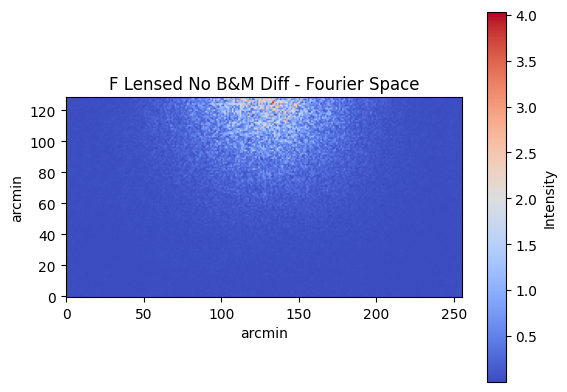

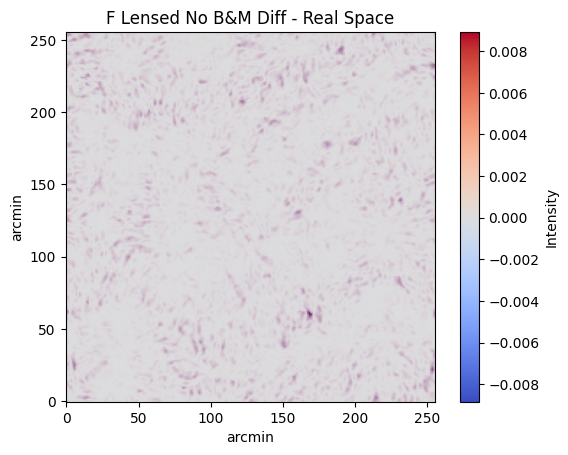

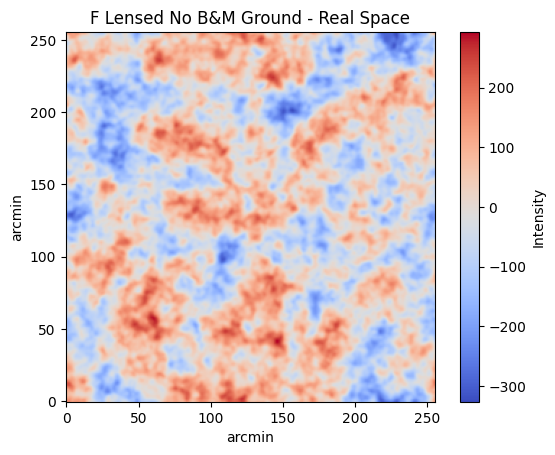

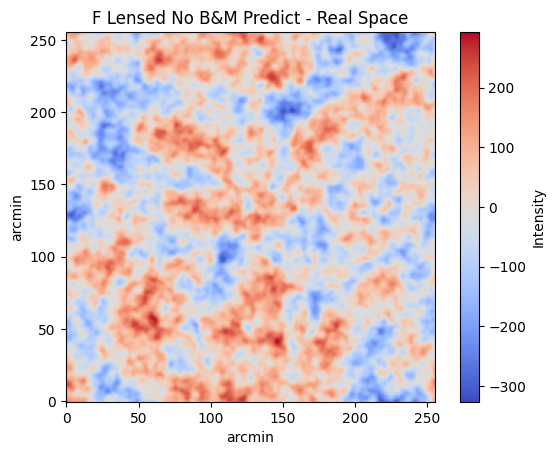

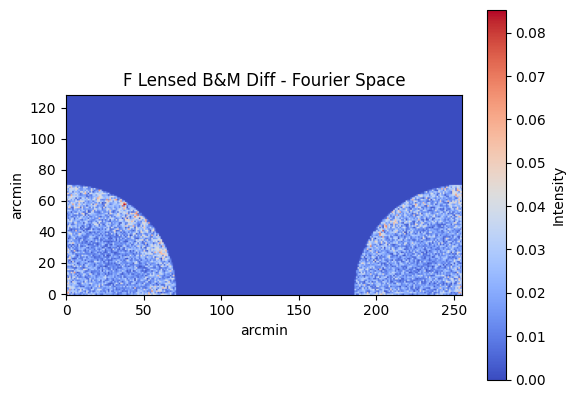

In [8]:
#--------------------------------------------------------------------------------------------------------------------------
#compare the difference between the lensed fields in fourier space - julia ground truth versus python computed values
#--------------------------------------------------------------------------------------------------------------------------

#COMMENTS: The error between f_lensed_julia and f_lense_python in fourier space exactly matches the error signal 
#between the julia and python gradients in fourier space except for the fact that the magnitude in the gradients
#is about 10^4 times larger. That seems to imply the error in the gradients is likely due to the error in f_lensed
#since Fourier[df/dx] = ik*Fourier[f] meaning small errors in Fourier[f] get linearly scaled by possibly
#large wavevectors which maintain the shape of the error signal but amplify it by orders of magntiude...

#necessary constants
pix_width = 0.00058177643
pix_width = (2/60)*(jnp.pi / 180) #2 arcminutes divided by 60 converted from degrees to radians
num_steps = 10 #to match Julia data

#get the file paths of the necessary data
f_array_file_path = "/home/zane-blood/Desktop/f_array.npz"
phi_array_file_path = "/home/zane-blood/Desktop/phi_array.npz"
f_lensed_array_file_path = "/home/zane-blood/Desktop/f_lensed_array.npz"
f_lensed_no_b_no_m_array_file_path = "/home/zane-blood/Desktop/f_lensed_no_b_no_m_array.npz"

#load the data into memory with precision format
f_array = jnp.array(np.load(f_array_file_path))
phi_array = jnp.array(np.load(phi_array_file_path))
f_lensed_array = jnp.array(np.load(f_lensed_array_file_path))
f_lensed_no_b_no_m_array = jnp.array(np.load(f_lensed_no_b_no_m_array_file_path))

#perform lense flow on the field
f_lensed_no_b_no_m_array_predict = LenseFlow(jfft.irfft2(f_array.T, s = (256, 256)).T, \
                                   jfft.irfft2(phi_array.T, s = (256, 256)).T, pix_width, num_steps)
#apply the M and B transformations
f_lensed_array_predict = m_diagonal * b_diagonal * jfft.rfft2(f_lensed_no_b_no_m_array_predict.T).T

#plot different comparisons
plot_heat_map(jnp.abs(jfft.rfft2(f_lensed_no_b_no_m_array_predict.T).T-f_lensed_no_b_no_m_array), \
              'F Lensed No B&M Diff - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(f_lensed_no_b_no_m_array_predict-jfft.irfft2(f_lensed_no_b_no_m_array.T).T, \
              'F Lensed No B&M Diff - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(f_lensed_no_b_no_m_array.T).T, \
              'F Lensed No B&M Ground - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(f_lensed_no_b_no_m_array_predict, \
              'F Lensed No B&M Predict - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(f_lensed_array), \
              'F Lensed B&M Ground - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(f_lensed_array_predict), \
              'F Lensed B&M Predict - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(f_lensed_array_predict-f_lensed_array), \
              'F Lensed B&M Diff - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(f_lensed_array_predict.T, s = (256, 256)).T-jfft.irfft2(f_lensed_array.T, s = (256, 256)).T, \
              'F Lensed B&M Diff - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

In [9]:
#---------------------------------------------------------------
#compute the analytical gradient of logpdf w.r.t. f
#---------------------------------------------------------------
def gradf_analytical(f, phi, data, m_diagonal, b_diagonal, cf_diagonal, cn_diagonal):

    #The analytical gradient of logpdf w.r.t f is given by:
    #grad_f = (L^dagger*B^dagger*M^dagger) * (C_n^-1) * (d - M*B*L*f) - (C_f^-1)*f

    #get (C_f^-1)
    cf_matrix = cf_diagonal.reshape((129, 256), order='F')
    f_covar_inv = jnp.where(cf_matrix != 0, 1.0/cf_matrix, 0.0)
    #get (C_n^-1)
    cn_matrix = cn_diagonal.reshape((129, 256), order='F')
    noise_covar_inv = jnp.where(cn_matrix != 0, 1.0/cn_matrix, 0.0)

    #properly format the B and M matrices and their adjoints
    b_matrix_fourier = b_diagonal.reshape((129, 256), order='F')
    #go back to real space, compute adjoint, transform back to fourier space
    b_matrix_real = jfft.irfft2(b_matrix_fourier.T, s=(256,256)).T
    b_dagger_real = jnp.conj(b_matrix_real).T #adjoint is complex conjugate transpose
    b_dagger_fourier = jfft.rfft2(b_dagger_real.T).T

    m_matrix_fourier = m_diagonal.reshape((129, 256), order='F')
    #go back to real space, compute adjoint, transform back to fourier space
    m_matrix_real = jfft.irfft2(m_matrix_fourier.T, s=(256,256)).T
    m_dagger_real = jnp.conj(m_matrix_real).T #adjoint is complex conjugate transpose
    m_dagger_fourier = jfft.rfft2(m_dagger_real.T).T

    #perform lense flow on f to compute L*f
    f_lensed = jfft.rfft2(LenseFlow(jfft.irfft2(f.T, s = (256, 256)).T, \
                                    jfft.irfft2(phi.T, s = (256, 256)).T, \
                                    pix_width, n = 10).T).T
    #perform the adjoint of lenseflow on (B^dagger*M^dagger) * (C_n^-1) * (d - M*B*L*f)
    lhs = jfft.rfft2(LenseFlow(jfft.irfft2((b_dagger_fourier*m_dagger_fourier*noise_covar_inv*\
                            (data-m_matrix_fourier*b_matrix_fourier*f_lensed)).T, s = (256, 256)).T, \
                            jfft.irfft2(phi.T, s = (256, 256)).T, \
                            pix_width, 10, -1, True).T).T

    #add this result to C_f^-1 and return the result
    rhs = -1*f_covar_inv*f
    grad_f = lhs + rhs
    return grad_f

In [ ]:
#---------------------------------------------------------------
#TODO: compute the analytical gradient of logpdf w.r.t. phi
#---------------------------------------------------------------

In [10]:
#--------------------------------------------------------------------------------
#compute the gradients with both jax and analytical theory, and compare to julia
#--------------------------------------------------------------------------------

#load ground truth / necessary data 
grad_f_fourier_weights_file_path = "/home/zane-blood/Desktop/grad_f_fourier_weights.npz" #these aren't currently used
grad_phi_fourier_weights_file_path = "/home/zane-blood/Desktop/grad_phi_fourier_weights.npz"
grad_f_fourier_weights = jnp.array(np.load(grad_f_fourier_weights_file_path))
grad_phi_fourier_weights = jnp.array(np.load(grad_phi_fourier_weights_file_path))

#compute predictions in python using jax
#seem to need to rescale these to match the ground truth more accurately
g_f_predict = 256*129*jnp.conj(jax.grad(logpdf_v2, argnums=0)(f_array, phi_array, data_array,
                                            b_diagonal, m_diagonal, 
                                            b_lambda_array, m_lambda_array,
                                            cf_diagonal, cphi_diagonal, cn_diagonal, 
                                            f_lambda_array, phi_lambda_array, data_lambda_array, 
                                            cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels)) # * grad_f_fourier_weights[:, jnp.newaxis])
g_phi_predict = 256*129*jnp.conj(jax.grad(logpdf_v2, argnums=1)(f_array, phi_array, data_array,
                                            b_diagonal, m_diagonal, 
                                            b_lambda_array, m_lambda_array,
                                            cf_diagonal, cphi_diagonal, cn_diagonal, 
                                            f_lambda_array, phi_lambda_array, data_lambda_array, 
                                            cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels)) # * grad_phi_fourier_weights[:, jnp.newaxis])

#compute the analytical / theory version of grad_f in python
g_f_analytical = gradf_analytical(f_array, phi_array, data_array, m_diagonal, b_diagonal, cf_diagonal, cn_diagonal)

#load the ground truth data
g_f_ground = jnp.array(np.load("/home/zane-blood/Desktop/grad_f.npz"))
g_phi_ground = jnp.array(np.load("/home/zane-blood/Desktop/grad_phi.npz"))

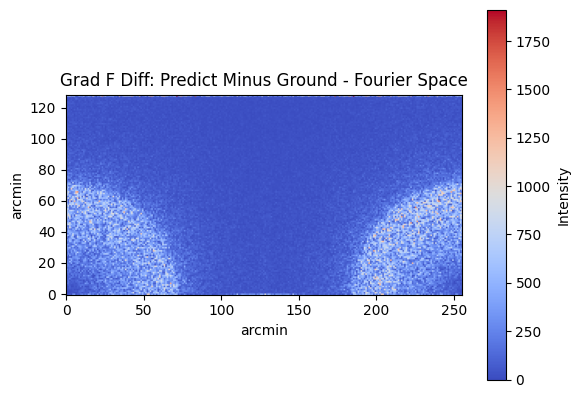

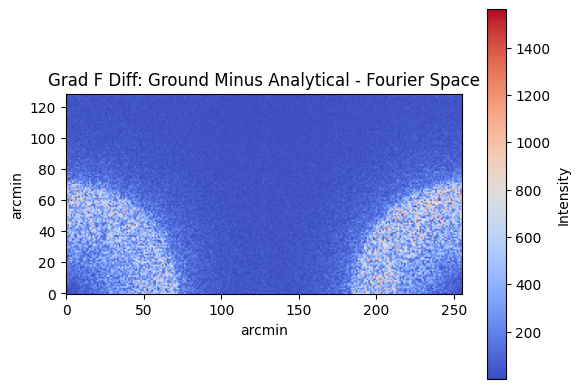

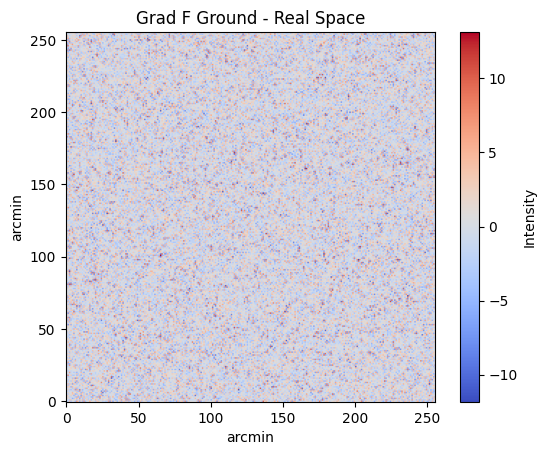

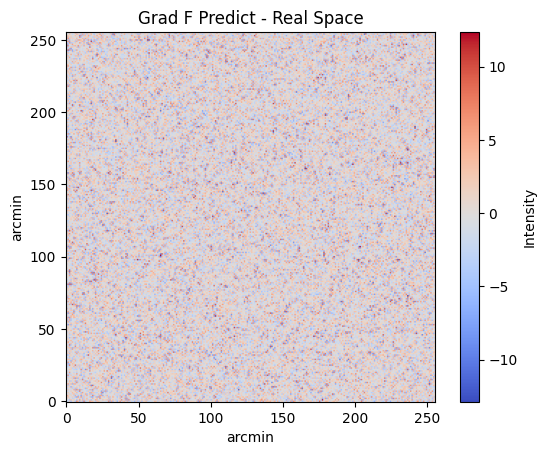

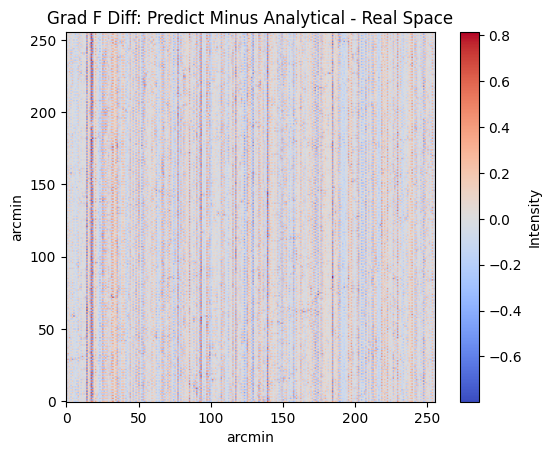

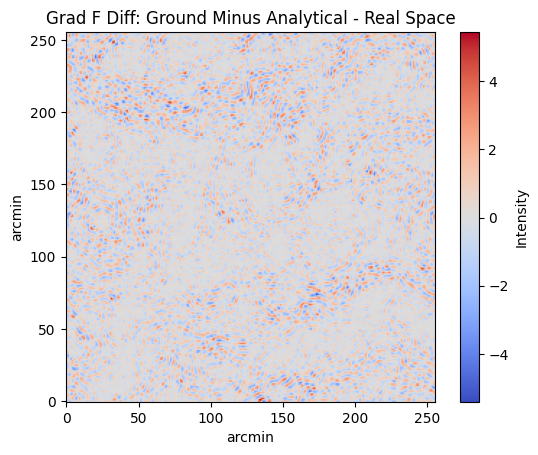

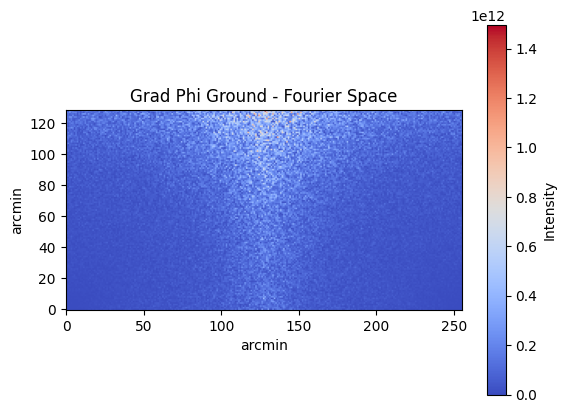

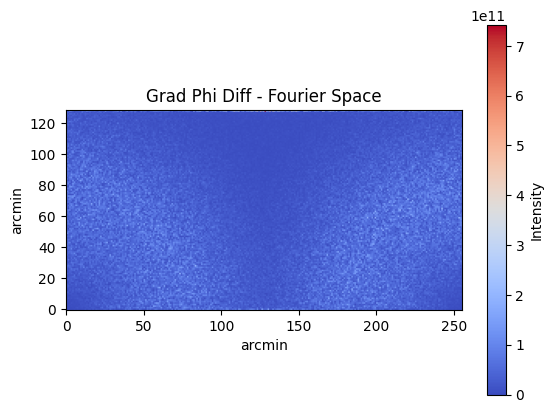

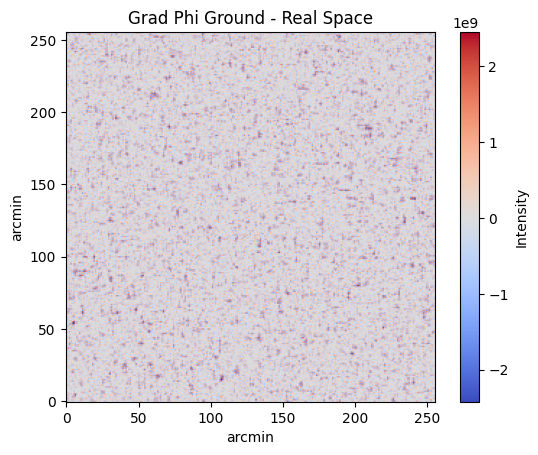

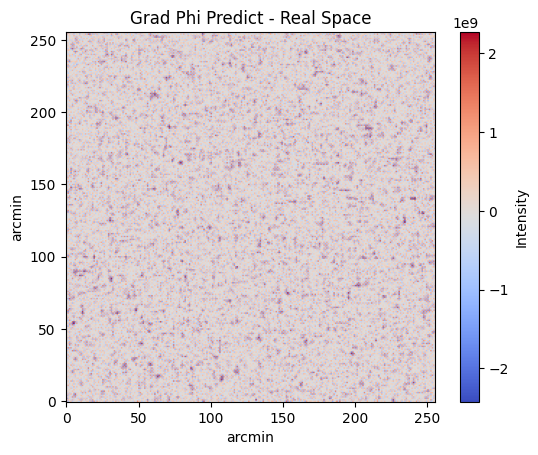

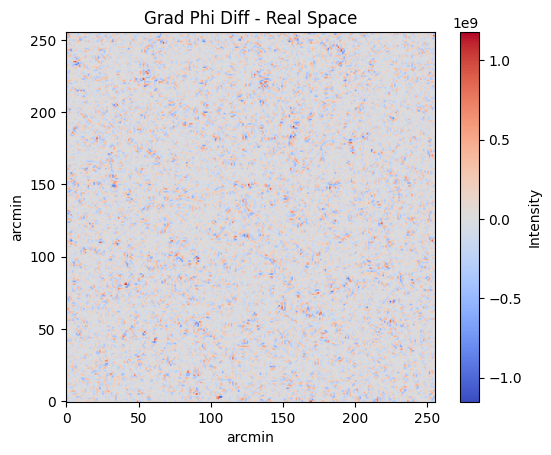

In [11]:
#---------------------------------------------------
#plot and compare the gradients
#---------------------------------------------------

#grad f comparison in fourier space
plot_heat_map(jnp.abs(g_f_ground), \
              'Grad F Ground - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(g_f_predict), \
              'Grad F Predict - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(g_f_analytical), \
              'Grad F Analytical - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(g_f_predict-g_f_ground), \
              'Grad F Diff: Predict Minus Ground - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(g_f_predict-g_f_analytical), \
              'Grad F Diff: Predict Minus Analytical - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(g_f_ground-g_f_analytical), \
              'Grad F Diff: Ground Minus Analytical - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')


#grad f comparison in real space
plot_heat_map(jfft.irfft2(g_f_ground.T, s = (256, 256)).T, \
              'Grad F Ground - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(g_f_predict.T, s = (256, 256)).T, \
              'Grad F Predict - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(g_f_analytical.T, s = (256, 256)).T, \
              'Grad F Analytical - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(g_f_predict.T, s = (256, 256)).T - jfft.irfft2(g_f_ground.T, s = (256, 256)).T, \
              'Grad F Diff: Predict Minus Ground - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(g_f_predict.T, s = (256, 256)).T - jfft.irfft2(g_f_analytical.T, s = (256, 256)).T, \
              'Grad F Diff: Predict Minus Analytical - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(g_f_analytical.T, s = (256, 256)).T - jfft.irfft2(g_f_ground.T, s = (256, 256)).T, \
              'Grad F Diff: Ground Minus Analytical - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

#grad phi comparison in fourier space
plot_heat_map(jnp.abs(g_phi_ground), \
              'Grad Phi Ground - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(g_phi_predict), \
              'Grad Phi Predict - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jnp.abs(g_phi_predict-g_phi_ground), \
              'Grad Phi Diff - Fourier Space', \
              'arcmin', 'arcmin', 'Intensity')

#grad phi comparison in real space
plot_heat_map(jfft.irfft2(g_phi_ground.T, s = (256, 256)).T, \
              'Grad Phi Ground - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(g_phi_predict.T, s = (256, 256)).T, \
              'Grad Phi Predict - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(g_phi_predict.T, s = (256, 256)).T - jfft.irfft2(g_phi_ground.T, s = (256, 256)).T, \
              'Grad Phi Diff - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

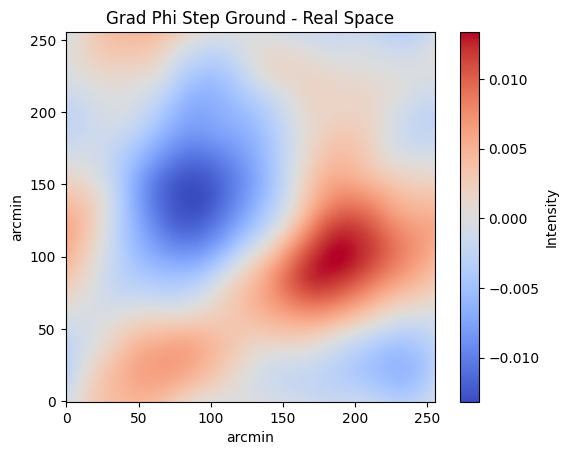

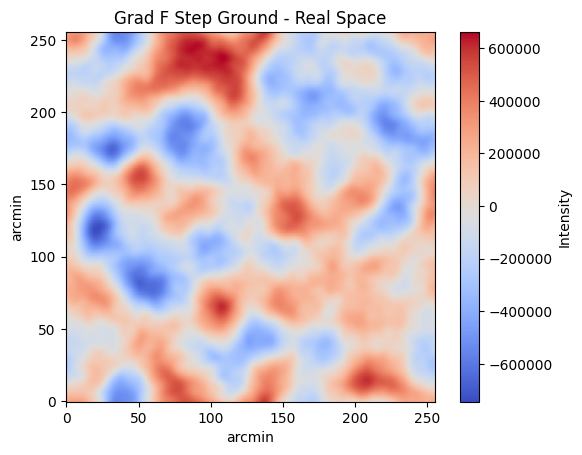

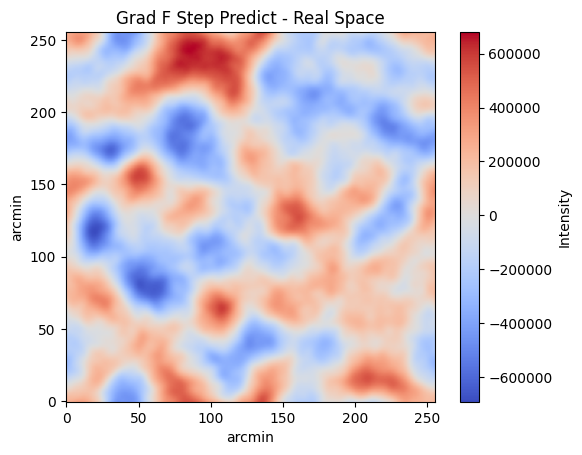

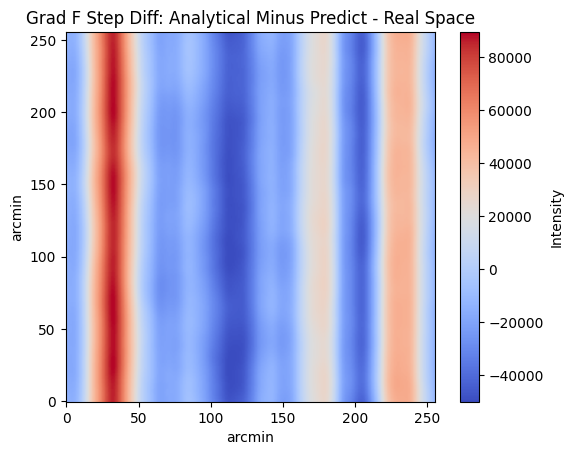

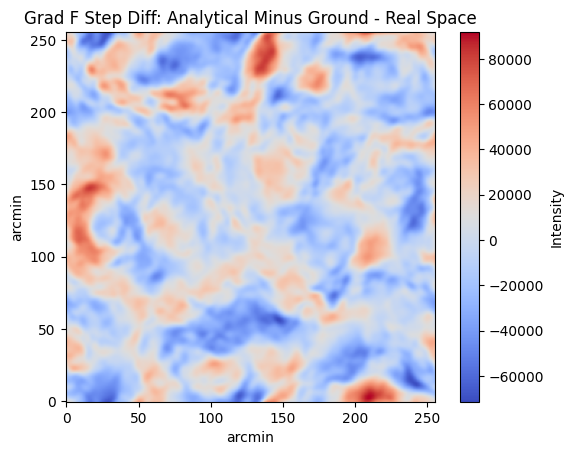

In [12]:
#------------------------------------------------------------------------------
#Comparing the predicted and ground truth phi and f gradient steps
#------------------------------------------------------------------------------

#for grad phi:
plot_heat_map(jfft.irfft2((g_phi_ground * cphi_diagonal.reshape((129, 256), order = 'F')).T, s = (256, 256)).T, \
              'Grad Phi Step Ground - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

plot_heat_map(-jfft.irfft2((g_phi_predict * cphi_diagonal.reshape((129, 256), order = 'F')).T).T, \
              'Grad Phi Step Predict - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

plot_heat_map(jfft.irfft2((g_phi_predict * cphi_diagonal.reshape((129, 256), order = 'F')).T).T +
              jfft.irfft2((g_phi_ground * cphi_diagonal.reshape((129, 256), order = 'F')).T, s = (256, 256)).T, \
              'Grad Phi Step Diff - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

#for grad f
plot_heat_map(jfft.irfft2((g_f_ground * cf_diagonal.reshape((129, 256), order = 'F')).T, s = (256, 256)).T, \
              'Grad F Step Ground - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

plot_heat_map(jfft.irfft2((g_f_predict * cf_diagonal.reshape((129, 256), order = 'F')).T).T, \
              'Grad F Step Predict - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

plot_heat_map(jfft.irfft2((g_f_analytical * cf_diagonal.reshape((129, 256), order = 'F')).T).T, \
              'Grad F Step Analytical - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

plot_heat_map(jfft.irfft2((g_f_predict * cf_diagonal.reshape((129, 256), order = 'F')).T).T -
              jfft.irfft2((g_f_ground * cf_diagonal.reshape((129, 256), order = 'F')).T, s = (256, 256)).T, \
              'Grad F Step Diff: Ground Minus Predict - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

plot_heat_map(jfft.irfft2((g_f_predict * cf_diagonal.reshape((129, 256), order = 'F')).T).T -
              jfft.irfft2((g_f_analytical * cf_diagonal.reshape((129, 256), order = 'F')).T, s = (256, 256)).T, \
              'Grad F Step Diff: Analytical Minus Predict - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

plot_heat_map(jfft.irfft2((g_f_ground * cf_diagonal.reshape((129, 256), order = 'F')).T).T -
              jfft.irfft2((g_f_analytical * cf_diagonal.reshape((129, 256), order = 'F')).T, s = (256, 256)).T, \
              'Grad F Step Diff: Analytical Minus Ground - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

In [ ]:
#-----------------------------------------------------------------------------------------------------------
#TRY TO ACTUALLY IMPLEMENT THE GRADIENT DESCENT ALGORITHM. TODO: Re-visit once gradients are accurate
#-----------------------------------------------------------------------------------------------------------

#set full printing (no truncation) for debugging
np.set_printoptions(threshold=np.inf)

#initialize f, phi, and f_lensed to 0
f_hat = jnp.zeros((129, 256))
phi_hat = jnp.zeros((129, 256))
f_lensed_hat = jnp.zeros((129, 256))

#small parameter to loop over for maximization line searches
alpha_max = 1
updated_alpha = False
#space step between pixels / real space value
pix_width = 0.00058177643
pix_width = (2/60)*(jnp.pi/180) #2 arcminutes converted to radians

#loop over a definite amount of user specified steps
num_steps = 30
max_logpdf_value = -1*float("inf")
for step_idx in range(num_steps):
    #at each step do the following:

    #1. compute b vector = negative grad_f evaluated @ f = 0, d = d, f_lensed = f_lensed
    #evidently need to rescale these gradients
    b_array = -1*jnp.conj(jax.grad(logpdf_v2, argnums=0)(jnp.zeros((129, 256)), phi_hat, data_array,
                                            b_diagonal, m_diagonal, 
                                            b_lambda_array, m_lambda_array,
                                            cf_diagonal, cphi_diagonal, cn_diagonal, 
                                            f_lambda_array, phi_lambda_array, data_lambda_array, 
                                            cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels))
    
    #2. compute A matrix = grad_f evaluated @ f = f, d = 0, f_lensed = f_lensed
    if step_idx == 0: #try initializing the first step for A matrix otherwise no evolution
        cf_matrix = cf_diagonal.reshape((129, 256), order='F')
        f_covar_inv = jnp.where(cf_matrix != 0, 1.0/cf_matrix, 0.0)

        cn_matrix = cn_diagonal.reshape((129, 256), order='F')
        noise_covar_inv = jnp.where(cn_matrix != 0, 1.0/cn_matrix, 0.0)
        
        A_array = noise_covar_inv + f_covar_inv #assuming the first step has lensing matrix == Identity

    else: #just default to jax for subsequent time steps
        A_array = jnp.conj(jax.grad(logpdf_v2, argnums=0)(f_hat, phi_hat, jnp.zeros((129, 256)),
                                                b_diagonal, m_diagonal, 
                                                b_lambda_array, m_lambda_array,
                                                cf_diagonal, cphi_diagonal, cn_diagonal, 
                                                f_lambda_array, phi_lambda_array, data_lambda_array, 
                                                cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels))

    #3. compute new f = A^-1 * b via conjugate gradient
    #convert A and b from fourier back into real keep track of row-column ordering and compute cg in real space
    f_hat, _ = cg(jfft.irfft2(A_array.T, s = (256, 256)).T, jfft.irfft2(b_array.T, s = (256, 256)).T, tol=1e-4, maxiter=100)
    #given the cg in real space, convert it back into fourier space keeping track of row-column ordering
    f_hat = jfft.rfft2(f_hat.T).T

    #debug:
    if jnp.all(jnp.isnan(f_hat)):
        print("f hat is all NaN")

    print("above")

    #4. lense the f value we just found to compute the new f_lensed_hat
    #NOTE: must convert back into real space to do this given the restrictions on LenseFlow inputs
    f_lensed_hat = jfft.rfft2(LenseFlow(jfft.irfft2(f_hat.T, s  = (256, 256)).T, \
                                        jfft.irfft2(phi_hat.T, s  = (256, 256)).T, pix_width).T).T

    print("below")

    #4. compute grad_phi at f, d and phi
    grad_phi = jnp.conj(jax.grad(logpdf_v2, argnums=1)(f_hat, phi_hat, data_array,
                                            b_diagonal, m_diagonal, 
                                            b_lambda_array, m_lambda_array,
                                            cf_diagonal, cphi_diagonal, cn_diagonal, 
                                            f_lambda_array, phi_lambda_array, data_lambda_array, 
                                            cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels))
    
    #check if grad_phi is all zero or all nan
    # if jnp.all(jnp.isnan(grad_phi)):
    #     print("Grad Phi NaN")
    # if jnp.all(grad_phi == 0):
    #      print("Grad Phi Zero")

    #5. loop over small values of alpha from -1 to +1 and find which version of
    #alpha causes logpdf(f, phi - alpha * C_phi * g_phi, d) to be maximized
    best_phi = phi_hat
    if not updated_alpha and step_idx != 0:
        #if we did not find an alpha by happenchance on the last run which maximized logpdf, 
        #try using a smaller alpha bound
        alpha_max = alpha_max/2
    updated_alpha = False
    alpha_array = jnp.linspace(0.5*alpha_max, 2*alpha_max, 100) #choose from alpha values from half to twice the previous best alpha
    for alpha in alpha_array:

        #print("grad_phi = "+ str(grad_phi))

        #should the following be a plus or a minus?
        test_phi = phi_hat + alpha * cphi_diagonal.reshape((129, 256), order = 'F') * grad_phi
        logpdf_value = logpdf_v2(f_hat, test_phi, data_array,
                                b_diagonal, m_diagonal, 
                                b_lambda_array, m_lambda_array,
                                cf_diagonal, cphi_diagonal, cn_diagonal, 
                                f_lambda_array, phi_lambda_array, data_lambda_array, 
                                cf_lambda_array, cphi_lambda_array, cn_lambda_array, num_pixels)
        
        #print("logpdf value = " + str(logpdf_value))

        if logpdf_value > max_logpdf_value: # and not jnp.all(jnp.isnan(grad_phi)):
            print("got here")
            max_logpdf_value = logpdf_value
            best_phi = test_phi
            alpha_max = alpha #make sure to update alpha so over time the gradient steps become smaller
            updated_alpha = True

    # 6. Update phi to be prev_phi - alpha * C_phi * g_phi for 
    # whichever alpha maximized the logpdf the most
    phi_hat = best_phi
    print("alpha max = " + str(alpha_max))

    plot_heat_map(jfft.irfft2(phi_hat.T, s = (256, 256)).T, \
              'MLE Phi - Real Space', \
              'arcmin', 'arcmin', 'Intensity')

    #print incremental progress to screen
    print("Finished iteration " + str(step_idx+1))

#after loop terminates, you have the MLE of f, phi, and f_lensed
plot_heat_map(jfft.irfft2(phi_hat.T, s = (256, 256)).T, \
              'MLE Phi - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(phi_array.T, s = (256, 256)).T, \
              'Ground Phi - Real Space', \
              'arcmin', 'arcmin', 'Intensity')
plot_heat_map(jfft.irfft2(phi_array.T, s = (256, 256)).T - jfft.irfft2(phi_hat.T, s = (256, 256)).T, \
              'Phi Diff - Real Space', \
              'arcmin', 'arcmin', 'Intensity')